## Question 2

In [1]:
%load_ext autoreload
%autoreload 2

### Section A- Supervised Machine Learning

**SOME OF OUR CODE PIECES ARE SAME AS OUR ASSIGNMENT 2 SOLUTION TO AVOID DUPLICATE CODE**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from utils import styled_print, download_data, read_and_clean_data, \
     plot_box_plot_hist_plot, plot_count_plot, discrete_to_target_plot, \
     continuous_to_target_plot, correlation_analysis, traditional_feature_importance

In [3]:
cleveland_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

In [4]:
headers = {
    0: "age",
    1: "sex",
    2: "cp",
    3: "trestbps",
    4: "chol",
    5: "fbs",
    6: "restecg",
    7: "thalach",
    8: "exang",
    9: "oldpeak",
    10: "slope",
    11: "ca",
    12: "thal",
    13: "target"
}

In [5]:
styled_print(f"Heart Disease Data Analysis", header=True)
styled_print(f"Extracting Data From {cleveland_url}")
cleveland_file = download_data(cleveland_url, path_to_download="./data")
cleveland_df = read_and_clean_data(cleveland_file, header=headers.values())

› Heart Disease Data Analysis
    Extracting Data From http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data


In [6]:
styled_print(f"Cleveland Dataframe Info", header=True)
cleveland_df.info()

› Cleveland Dataframe Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


#### Dataset Understanding and Observations

Here are some observations from the `heart-disease.names` file regarding the features.

1. `age` is a `continuous` feature which indicates the age of the person in years. 
2. `sex` is a `binary categorical` feature indicating sex information.
    - 1 : male
    - 0 : female
3. `cp` is a `categorical` feature which indicates the type of chest pain.
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. `trestbps` is a `continuous` feature indicating resting blood pressure (in mm Hg on admission to the hospital).
5. `chol` is a `continuous` feature indicating serum cholestoral in mg/dl.
6. `fbs` is a `binary categorical` feature indicating fasting blood sugar > 120 mg/dl.
    - 1 : true
    - 0 : false
7. `restecg` is a `categorical` feature indicating resting electrocardiographic results.
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. `thalach` is a `continuous` feature indicating maximum heart rate achieved.
9. `exang` is a `binary categorical` feature indicating exercise induced angina.
    - 1 : yes
    - 0 : no
10. `oldpeak` is a `continuos` feature indicating ST depression induced by exercise relative to rest.
11. `slope` is a `categorical`feature indicating the slope of the peak exercise ST segment.
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. `ca` is a `categorical` feature indicating number of major vessels (0-3) colored by flourosopy.
13. `thal` is a `categorical` feature.
    - 3 : normal
    - 6 : fixed defect
    - 7 : reversable defect
14. `target` is a `categorical` feature (target) indicating the diagnosis of heart disease (angiographic disease status)

**Two main observations:** 
1. As all of over categorical features are already numerically encoded we will treat them as discrete feature and not traditional categorical features. 
2. As provided in `heart-disease.names` file:

    ```The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).```

    So Initially We can convert the `target` into two categories 
    - 0: Absence of Heart disease
    - 1: Presence of Heart disease (Combine current categories 1, 2, 3, and 4)

In [7]:
categorical_columns = ["cp", "restecg", "slope", "thal", "ca"]
binary_columns = ["sex", "fbs", "exang"]

continuous_columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
discrete_columns = categorical_columns + binary_columns
target_column = ["target"]

In [8]:
# Creating Copy of Dataframe for Data Processing
data_df = cleveland_df.copy()

#### Data Preprocessing and Exploratory Data Analysis

##### Preprocessing Target

In [9]:
# Check unique values for target and its percentage
data_df["target"].value_counts(dropna=False)

0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64

In [10]:
# Mapping target 2, 3, and 4 to 1. 
target_mapping = {2: 1, 3: 1, 4: 1}
data_df["target"] = data_df["target"].apply(lambda x: 1 if x == 2 or x == 3 or x == 4 else x)

In [11]:
# Check unique values for target and its percentage
data_df["target"].value_counts(dropna=False)

0    164
1    139
Name: target, dtype: int64

##### Splitting The Data

To split the data we are using `train_test_split()` method from `sklearn's` `model_selection` module. The splitting is based on the following parameters:
1. `test_size` is set to `0.2`. It will makes sure that we have 20% of our data for testing and rest 80% of data we can use for training and/or cross-validation.
2. `random_state` is set to `10`. We can set it to any fix number as it will help us in reproducibility of our experiment.
3. `stratify` is set to `target` feature. This will ensure the stratified sampling process. In simple words it will make sure that the distribution of Heart Disease and Non-Heart Disease patient remains as it is even after the split. Refer [this](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels) for further details. 
4. `shuffle` is set to `True`.

In [12]:
train_df, test_df = train_test_split(data_df, test_size=.2, random_state=10, stratify=data_df["target"], shuffle=True)

Let's check how stratify sampling make sure that the distribution of data is balance after the split too. 

In [13]:
# Check unique values for target and its percentage
data_df["target"].value_counts(normalize=True)*100

0    54.125413
1    45.874587
Name: target, dtype: float64

In [14]:
# Check unique values for target and its percentage
train_df["target"].value_counts(normalize=True)*100

0    54.132231
1    45.867769
Name: target, dtype: float64

In [15]:
# Check unique values for target and its percentage
test_df["target"].value_counts(normalize=True)*100

0    54.098361
1    45.901639
Name: target, dtype: float64

As we can see that in both training and testing dataset, `54%` of data comes from the `label 0` i.e. Absence of Heart Disease while `46%` of data comes from the `label 1` i.e. Presence of Heart Disease. **These percentages matches the percentage distribution in original dataset.**

In [16]:
styled_print(f"There are {train_df.shape[0]} data points for training and {test_df.shape[0]} data points for testing.", header=True)

› There are 242 data points for training and 61 data points for testing.


**Why are we splitting data first before any exploratory data analysis or even treating missing values??**

Our reasoning to split the data at the very beginning of workflow is to make sure that we can ensure that there is no data leak issues.
For example, we usually use median value to replace the missing values in a continuous feature. We want to make sure that the median value which we calculate comes only from the training set and we apply it to test set. This way we can gurantee that even in data preprocessing we are not introducing any direct or indirect data leak issues. 

This fact is usually ignored in many books and material but in practice it is heavily been used. 


##### Missing Value Treatment

In [17]:
train_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          3
thal        2
target      0
dtype: int64

In [18]:
test_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          1
thal        0
target      0
dtype: int64

As we have a very small number of missing values in the training and test dataset, it would be better to drop those rows instead of trying to figure out strategy to replace them. 

In [19]:
train_df = train_df.dropna()
test_df = test_df.dropna()

Let's verify that all the rows with missing values are dropped. 

In [20]:
train_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [21]:
test_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [22]:
styled_print(f"There are {train_df.shape[0]} data points for training and {test_df.shape[0]} data points for testing.")

    There are 237 data points for training and 60 data points for testing.


#### Model Creation

We will follow these steps to create the `BASELINE` model:
- Prepare the data for modeling.
    - Create X and Y - (x_train, y_train) and (x_test, y_test)
    - Scale Continuous Features using Standard Scaler.
    - Scale Discrete Features using Standard Scaler.
- Build the `BASELINE` model on the train data.
    - Create `Losgistic Regression` Model
- Build the `IMPROVED` model on the train data.
    - Create `Neural Network` Model
- Test the model on the test set.
    - Calculate $MAE$ score to measure the performance of the model.
    - Calculate $Confusion \ Matrix$.
    - Calculate $Classification \ Report$ to get Precision, Recall and F1 Score.

Here `BASELINE` model means
    - We will use all features to create the model.

Later we will improve the model based on the learnings from the `BASELINE` model.

##### Prepare the data for modeling

In [23]:
y_train = train_df[target_column[0]].copy()
x_train = train_df.drop(target_column[0], axis=1)

In [24]:
y_test = test_df[target_column[0]].copy()
x_test = test_df.drop(target_column[0], axis=1)

In [25]:
x_train_copy = x_train.copy(deep=True).reset_index(drop=True)
x_test_copy = x_test.copy(deep=True).reset_index(drop=True)

In [26]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train),columns = x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)

In [27]:
x_train_copy.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0
1,48.0,1.0,4.0,130.0,256.0,1.0,2.0,150.0,1.0,0.0,1.0,2.0,7.0
2,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0
3,63.0,0.0,2.0,140.0,195.0,0.0,0.0,179.0,0.0,0.0,1.0,2.0,3.0
4,49.0,0.0,2.0,134.0,271.0,0.0,0.0,162.0,0.0,0.0,2.0,0.0,3.0
5,57.0,1.0,4.0,152.0,274.0,0.0,0.0,88.0,1.0,1.2,2.0,1.0,7.0
6,60.0,0.0,4.0,158.0,305.0,0.0,2.0,161.0,0.0,0.0,1.0,0.0,3.0
7,65.0,0.0,3.0,140.0,417.0,1.0,2.0,157.0,0.0,0.8,1.0,1.0,3.0
8,43.0,0.0,3.0,122.0,213.0,0.0,0.0,165.0,0.0,0.2,2.0,0.0,3.0
9,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0


In [28]:
x_train.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.904034,-1.441500,0.892576,1.028464,2.971492,-0.430116,1.043141,0.214538,-0.673786,2.674191,0.665067,2.484568,1.162183
1,-0.748326,0.693722,0.892576,-0.099206,0.137778,2.324953,1.043141,0.044486,1.484150,-0.919703,-1.029781,1.408073,1.162183
2,-0.528011,0.693722,0.892576,1.028464,-0.106184,-0.430116,1.043141,-0.890801,-0.673786,1.416328,0.665067,-0.744916,1.162183
3,0.904034,-1.441500,-1.181351,0.464629,-1.006967,-0.430116,-0.966814,1.277365,-0.673786,-0.919703,-1.029781,1.408073,-0.901018
4,-0.638169,-1.441500,-1.181351,0.126328,0.419273,-0.430116,-0.966814,0.554643,-0.673786,-0.919703,0.665067,-0.744916,-0.901018
5,0.243090,0.693722,0.892576,1.141232,0.475572,-0.430116,-0.966814,-2.591323,1.484150,0.158465,0.665067,0.331578,1.162183
6,0.573562,-1.441500,0.892576,1.479533,1.057328,-0.430116,1.043141,0.512130,-0.673786,-0.919703,-1.029781,-0.744916,-0.901018
7,1.124348,-1.441500,-0.144387,0.464629,3.159156,2.324953,1.043141,0.342078,-0.673786,-0.200924,-1.029781,0.331578,-0.901018
8,-1.299113,-1.441500,-0.144387,-0.550275,-0.669174,-0.430116,-0.966814,0.682182,-0.673786,-0.740009,0.665067,-0.744916,-0.901018
9,0.683719,0.693722,0.892576,0.351862,-1.551191,-0.430116,1.043141,-1.018340,1.484150,2.314801,0.665067,0.331578,-0.901018


In [29]:
x_test_copy.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,41.0,0.0,3.0,112.0,268.0,0.0,2.0,172.0,1.0,0.0,1.0,0.0,3.0
1,64.0,1.0,4.0,120.0,246.0,0.0,2.0,96.0,1.0,2.2,3.0,1.0,3.0
2,43.0,1.0,4.0,120.0,177.0,0.0,2.0,120.0,1.0,2.5,2.0,0.0,7.0
3,35.0,1.0,4.0,126.0,282.0,0.0,2.0,156.0,1.0,0.0,1.0,0.0,7.0
4,56.0,1.0,2.0,130.0,221.0,0.0,2.0,163.0,0.0,0.0,1.0,0.0,7.0
5,54.0,1.0,3.0,125.0,273.0,0.0,2.0,152.0,0.0,0.5,3.0,1.0,3.0
6,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0
7,63.0,0.0,3.0,135.0,252.0,0.0,2.0,172.0,0.0,0.0,1.0,0.0,3.0
8,41.0,0.0,2.0,105.0,198.0,0.0,0.0,168.0,0.0,0.0,1.0,1.0,3.0
9,46.0,1.0,4.0,120.0,249.0,0.0,2.0,144.0,0.0,0.8,1.0,0.0,7.0


In [30]:
x_test.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-1.519427,-1.441500,-0.144387,-1.114110,0.362974,-0.430116,1.043141,0.979773,1.484150,-0.919703,-1.029781,-0.744916,-0.901018
1,1.014191,0.693722,0.892576,-0.663042,-0.049885,-0.430116,1.043141,-2.251219,1.484150,1.056938,2.359914,0.331578,-0.901018
2,-1.299113,0.693722,0.892576,-0.663042,-1.344761,-0.430116,1.043141,-1.230905,1.484150,1.326480,0.665067,-0.744916,1.162183
3,-2.180371,0.693722,0.892576,-0.324741,0.625702,-0.430116,1.043141,0.299565,1.484150,-0.919703,-1.029781,-0.744916,1.162183
4,0.132932,0.693722,-1.181351,-0.099206,-0.519043,-0.430116,1.043141,0.597156,-0.673786,-0.919703,-1.029781,-0.744916,1.162183
5,-0.087382,0.693722,-0.144387,-0.381124,0.456805,-0.430116,1.043141,0.129512,-0.673786,-0.470466,2.359914,0.331578,-0.901018
6,0.353247,0.693722,0.892576,-1.001343,1.301290,-0.430116,0.038164,-0.380644,-0.673786,3.033580,2.359914,2.484568,0.646383
7,0.904034,-1.441500,-0.144387,0.182711,0.062713,-0.430116,1.043141,0.979773,-0.673786,-0.919703,-1.029781,-0.744916,-0.901018
8,-1.519427,-1.441500,-1.181351,-1.508795,-0.950669,-0.430116,-0.966814,0.809721,-0.673786,-0.919703,-1.029781,0.331578,-0.901018
9,-0.968641,0.693722,0.892576,-0.663042,0.006414,-0.430116,1.043141,-0.210592,-0.673786,-0.200924,-1.029781,-0.744916,1.162183


##### Build the `BASELINE` model on the train data.

In [31]:
logistic_regression = LogisticRegression(
    penalty='l1', 
    solver='liblinear', 
    multi_class='ovr', 
    fit_intercept=True, 
    n_jobs=-1,
    random_state=0
)
logistic_regression.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


LogisticRegression(multi_class='ovr', n_jobs=-1, penalty='l1', random_state=0,
                   solver='liblinear')

In [32]:
train_mean_acc = logistic_regression.score(x_train, y_train, sample_weight=None)
test_mean_acc = logistic_regression.score(x_test, y_test, sample_weight=None)

In [33]:
styled_print("Performance of Baseline Logistic Regression Model", header=True)
styled_print(f"The train Mean Accuracy for Logistic Regression is {train_mean_acc}")
styled_print(f"The test Mean Accuracy for Logistic Regression is {test_mean_acc}")

› Performance of Baseline Logistic Regression Model
    The train Mean Accuracy for Logistic Regression is 0.8481012658227848
    The test Mean Accuracy for Logistic Regression is 0.85


In [34]:
y_train_pred = logistic_regression.predict(x_train)
y_test_pred = logistic_regression.predict(x_test)

In [35]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [36]:
styled_print("Performance of Baseline Logistic Regression Model", header=True)
styled_print(f"The train Mean Absolute Error for Logistic Regression is {train_mae}")
styled_print(f"The test Mean Absolute Error for Logistic Regression is {test_mae}")

› Performance of Baseline Logistic Regression Model
    The train Mean Absolute Error for Logistic Regression is 0.1518987341772152
    The test Mean Absolute Error for Logistic Regression is 0.15


In [37]:
target_names = ['No Heart Disease', 'Heart Disease']
print(classification_report(y_train, y_train_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.85      0.88      0.86       128
   Heart Disease       0.85      0.82      0.83       109

        accuracy                           0.85       237
       macro avg       0.85      0.85      0.85       237
    weighted avg       0.85      0.85      0.85       237



In [38]:
y_test_pred = logistic_regression.predict(x_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.83      0.91      0.87        32
   Heart Disease       0.88      0.79      0.83        28

        accuracy                           0.85        60
       macro avg       0.85      0.85      0.85        60
    weighted avg       0.85      0.85      0.85        60



Text(0.5, 1.0, 'Accuracy Score: 0.85')

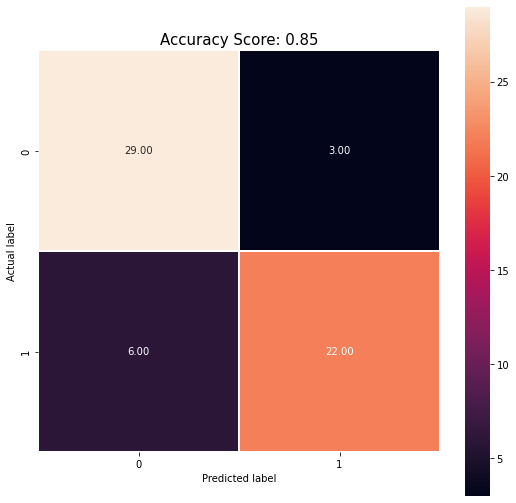

In [39]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(test_mean_acc)
plt.title(all_sample_title, size = 15)

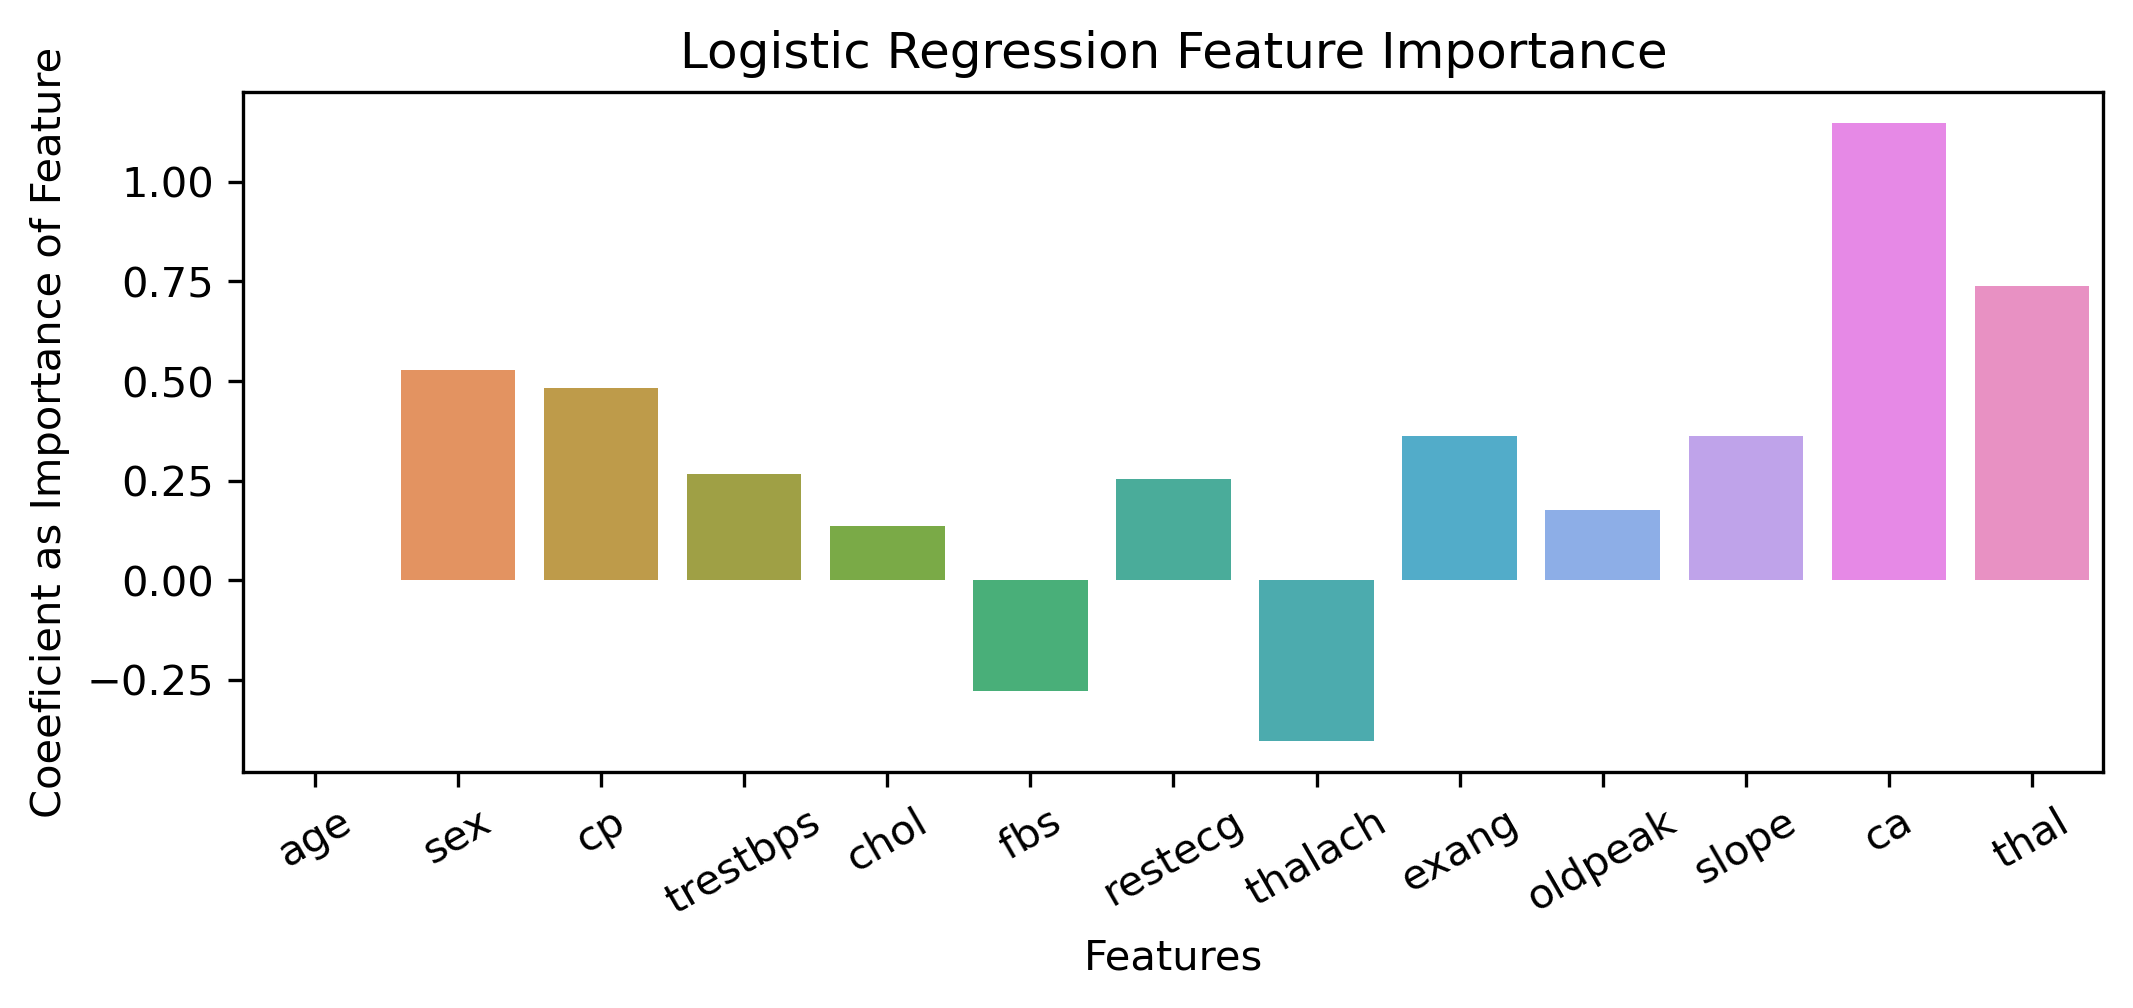

In [40]:
feature_importance = traditional_feature_importance(logistic_regression, x_train, figsize=(8, 3), title="Logistic Regression Feature Importance")

Logistic Regression outputs the log odds of $Y = 1$. This means that to extract the actual coeffients we need to apply exponetial to the coefficient we got. 



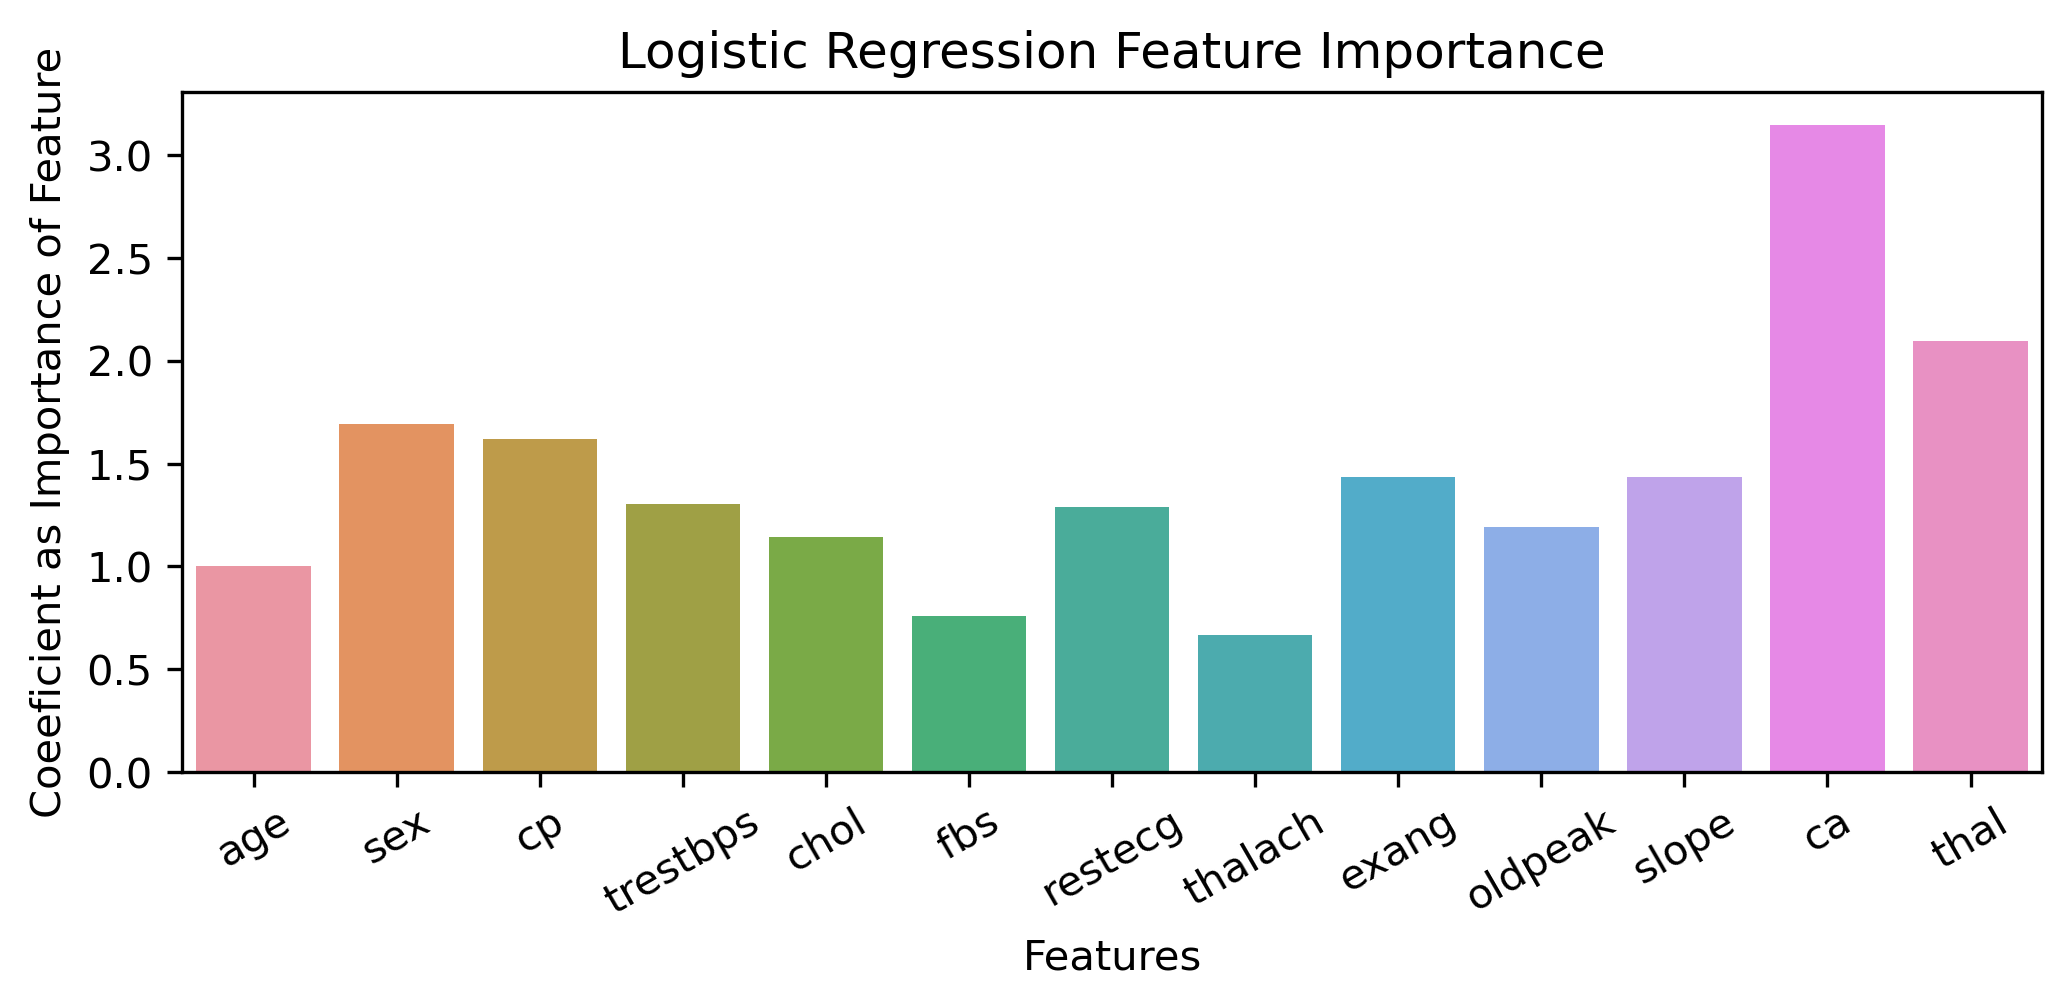

In [41]:
feature_importance = traditional_feature_importance(logistic_regression, x_train, apply_ln=True, figsize=(8, 3), title="Logistic Regression Feature Importance")

##### Build the `IMPROVED` neural network model on the train data.

In [42]:
ann = MLPClassifier(
    hidden_layer_sizes=(16, 32, 32, 64, 128),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=64,
    learning_rate_init=0.0001,
    n_iter_no_change=10,
    random_state=0
)
ann.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, batch_size=64,
              hidden_layer_sizes=(16, 32, 32, 64, 128),
              learning_rate_init=0.0001, random_state=0)

In [43]:
train_mean_acc = ann.score(x_train, y_train, sample_weight=None)
test_mean_acc = ann.score(x_test, y_test, sample_weight=None)

In [44]:
styled_print("Performance of Baseline Artificial Neural Network Model", header=True)
styled_print(f"The train Mean Accuracy for Artificial Neural Network is {train_mean_acc}")
styled_print(f"The test Mean Accuracy for Artificial Neural Network is {test_mean_acc}")

› Performance of Baseline Artificial Neural Network Model
    The train Mean Accuracy for Artificial Neural Network is 0.8945147679324894
    The test Mean Accuracy for Artificial Neural Network is 0.7666666666666667


In [45]:
y_train_pred = ann.predict(x_train)
y_test_pred = ann.predict(x_test)

In [46]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [47]:
styled_print("Performance of Baseline Artificial Neural Network Model", header=True)
styled_print(f"The train Mean Absolute Error for Artificial Neural Network is {train_mae}")
styled_print(f"The test Mean Absolute Error for Artificial Neural Network is {test_mae}")

› Performance of Baseline Artificial Neural Network Model
    The train Mean Absolute Error for Artificial Neural Network is 0.10548523206751055
    The test Mean Absolute Error for Artificial Neural Network is 0.23333333333333334


In [48]:
target_names = ['No Heart Disease', 'Heart Disease']
y_train_pred = ann.predict(x_train)
print(classification_report(y_train, y_train_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.89      0.92      0.90       128
   Heart Disease       0.90      0.86      0.88       109

        accuracy                           0.89       237
       macro avg       0.90      0.89      0.89       237
    weighted avg       0.89      0.89      0.89       237



In [49]:
y_test_pred = ann.predict(x_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.72      0.91      0.81        32
   Heart Disease       0.85      0.61      0.71        28

        accuracy                           0.77        60
       macro avg       0.79      0.76      0.76        60
    weighted avg       0.78      0.77      0.76        60



Text(0.5, 1.0, 'Accuracy Score: 0.7666666666666667')

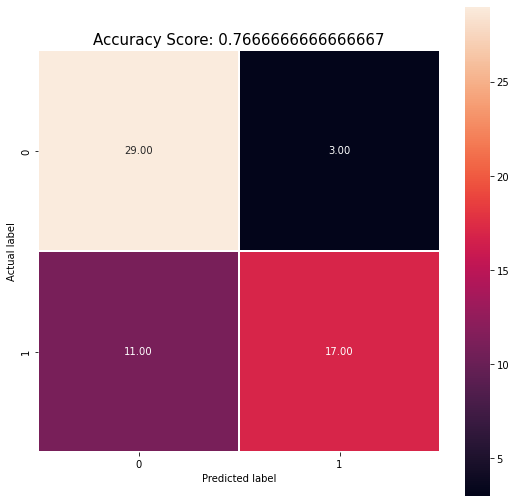

In [50]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(test_mean_acc)
plt.title(all_sample_title, size = 15)

As we can see that the neural network model is not able to beat the performance of Logistic Regression. These results are also overfitting because the performance on testing set is very poor as compared to performance on training set. 

Let's use GridSearch to find the right set of hyperparameters for Neural Network.

In [51]:
ann = MLPClassifier(random_state=0)
parameter_space = {
    'hidden_layer_sizes': [
        (100,),
        (16, 32),
        (16, 32, 64),
        (16, 32, 32, 64, 128),
        (16, 32, 32, 64, 64, 128),
        (16, 32, 32, 64, 64, 128, 128),
    ],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0, 0.01, 0.001, 0.0001, 0.05, 1.0],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [25, 50, 75, 100, 125, 150, 175, 200, 250, 300],
    'batch_size': [32, 64],
    'learning_rate_init': [0.001, 0.0001]
}
grid = GridSearchCV(ann, parameter_space, n_jobs=-1, cv=5)
grid.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=0), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0, 0.01, 0.001, 0.0001, 0.05, 1.0],
                         'batch_size': [32, 64],
                         'hidden_layer_sizes': [(100,), (16, 32), (16, 32, 64),
                                                (16, 32, 32, 64, 128),
                                                (16, 32, 32, 64, 64, 128),
                                                (16, 32, 32, 64, 64, 128, 128)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.0001],
                         'max_iter': [25, 50, 75, 100, 125, 150, 175, 200, 250,
                                      300],
                         'solver': ['sgd', 'adam']})

In [72]:
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [53]:
print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 1.0, 'batch_size': 32, 'hidden_layer_sizes': (16, 32, 32, 64, 128), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 75, 'solver': 'sgd'}


In [63]:
ann = MLPClassifier(
    activation='tanh', 
    alpha=1.0,
    batch_size=32,
    hidden_layer_sizes=(16, 32, 32, 64, 128),
    learning_rate='constant', 
    max_iter=75, 
    solver= 'sgd',
    learning_rate_init=0.001,
    random_state=0
)
ann.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', alpha=1.0, batch_size=32,
              hidden_layer_sizes=(16, 32, 32, 64, 128), max_iter=75,
              random_state=0, solver='sgd')

In [64]:
train_mean_acc = ann.score(x_train, y_train, sample_weight=None)
test_mean_acc = ann.score(x_test, y_test, sample_weight=None)

In [65]:
styled_print("Performance of Baseline Artificial Neural Network Model", header=True)
styled_print(f"The train Mean Accuracy for Artificial Neural Network is {train_mean_acc}")
styled_print(f"The test Mean Accuracy for Artificial Neural Network is {test_mean_acc}")

› Performance of Baseline Artificial Neural Network Model
    The train Mean Accuracy for Artificial Neural Network is 0.8565400843881856
    The test Mean Accuracy for Artificial Neural Network is 0.85


In [66]:
y_train_pred = ann.predict(x_train)
y_test_pred = ann.predict(x_test)

In [67]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

In [68]:
styled_print("Performance of Baseline Artificial Neural Network Model", header=True)
styled_print(f"The train Mean Absolute Error for Artificial Neural Network is {train_mae}")
styled_print(f"The test Mean Absolute Error for Artificial Neural Network is {test_mae}")

› Performance of Baseline Artificial Neural Network Model
    The train Mean Absolute Error for Artificial Neural Network is 0.14345991561181434
    The test Mean Absolute Error for Artificial Neural Network is 0.15


In [69]:
target_names = ['No Heart Disease', 'Heart Disease']
y_train_pred = ann.predict(x_train)
print(classification_report(y_train, y_train_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.86      0.88      0.87       128
   Heart Disease       0.86      0.83      0.84       109

        accuracy                           0.86       237
       macro avg       0.86      0.85      0.86       237
    weighted avg       0.86      0.86      0.86       237



In [70]:
y_test_pred = ann.predict(x_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.83      0.91      0.87        32
   Heart Disease       0.88      0.79      0.83        28

        accuracy                           0.85        60
       macro avg       0.85      0.85      0.85        60
    weighted avg       0.85      0.85      0.85        60



Text(0.5, 1.0, 'Accuracy Score: 0.85')

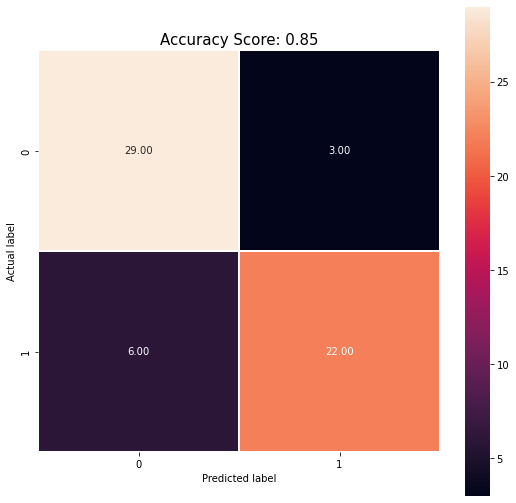

In [71]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(test_mean_acc)
plt.title(all_sample_title, size = 15)

**Observations**

- Neural Network with GridSearch is able to outperform the Logistic Regression.
- Training Neural Networks takes lots of time and lots of hyperparameter tunning. Without proper tunning Neural Network might not give us the best performance possible from it. 